In [12]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt

## Model background
Here is an example based on the model of Freyberg, 1988.  The synthetic model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg, 1988; the last stress period use 25% less recharge and 25% more pumping.

The inverse problem has 761 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yield, calibration and forecast well flux for each of the six wells, and river bed conductance for each 40 cells with river-type boundary conditions.  The inverse problem has 12 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during both stress periods (observations named ```sw_gw_0``` and ``sw_gw_1``), and the water level in well cell 6 located in at row 28 column 5 at the end of the stress periods (observations named ```or28c05_0``` and ```or28c05_1```).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

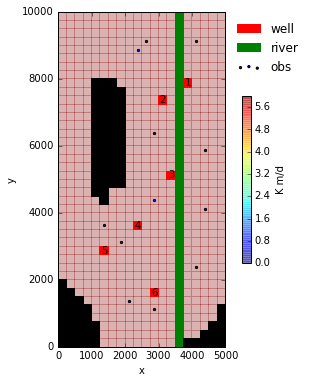

In [13]:
import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar="K m/d",alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.dis.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.dis.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="obs")

#plot names on the pumping well locations
wel_data = ml.wel.stress_period_data[0]
wel_x = ml.dis.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = ml.dis.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.5,1.0),frameon=False)
plt.savefig("domain.pdf")

The plot shows the Freyberg (1988) model domain.  The colorflood is the hydraulic conductivity ($\frac{m}{d}$).  Red and green cells coorespond to well-type and river-type boundary conditions. Blue dots indicate the locations of water levels used for calibration.

## Using `pyemu`

In [14]:
import pyemu

First create a linear analysis object.  We will use `MonteCarlo`  derived type, which allows us to use some sampling based methods.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.

In [15]:
# get the list of forecast names from the pest++ argument in the pest control file
jco = os.path.join("freyberg","freyberg.jcb")
pst = pyemu.Pst(jco.replace("jcb","pst"))
mc = pyemu.MonteCarlo(jco=jco, forecasts=pst.pestpp_options["forecasts"].split(','),verbose=False)
print("observations,parameters in jacobian:",mc.jco.shape)


observations,parameters in jacobian: (704, 761)


## Drawing from the prior
Each ``MonteCarlo`` instance has a ``parensemble`` attribute which itself is an instance of ``Ensemble`` class, which is derived from ``pandas.DataFrame``.  What all that means is that the parameter ensembles behave just like ```DataFrame```s

### ```draw```
The ``draw`` method is the main entry point into getting realizations. It accepts several optional arguments.  Without any args, it makes a single draw from the prior, which uses a $\boldsymbol{\mu}$ (mean) vector of the parameter values listed in the pest control file:


In [16]:
mc.draw()
print(mc.parensemble.shape)

(1, 761)


``draw`` also accepts a ``num_reals`` argument to specify the number of draws to make:

In [17]:
mc.draw(num_reals=200)
print(mc.parensemble.shape)
print(mc.parensemble.mean().head())

(200, 761)
parnme
rcond03      9872.902539
rch_1           1.004424
rcond04     10337.797844
hkr26c02       11.840997
wf5_1          62.248955
dtype: float64


Notice that each call to ``draw`` overwrites the previous draws.  ```draw``` also accepts a ``par_file`` argument in the case that you want to use a pest .par file as the $\boldsymbol{\mu}$ vector.

In [18]:
mc.draw(num_reals=200,par_file=jco.replace(".jcb",".par"))
print(mc.parensemble.mean().head())

parnme
rcond03     9778.497711
rch_1          1.012583
rcond04     7806.336796
hkr26c02      11.221585
wf5_1         46.771637
dtype: float64


Notice how the mean value for ``rond00`` is different.  ``draw`` also accepts an ``obs`` boolean flag to control include drawing a realization of observation noise.  If ```obs``` is True, then a complimentary ```obsensemble``` attribute is also populated.  The last optional flag for ```draw``` is ``enforce_bounds``, which controls whether parameter bounds are explicitly respected:

```.draw``` also accepts an optional ``how`` argument that controls the type of distribution to draw from.  ``how`` can be either "gaussian" (default) or "uniform".  

## plotting

Since ```ParameterEnsemble``` is dervied from ```pandas.DataFrame```, it has all the cool methods and attributes we all love.  Let's compare the results of drawing from a uniform vs a gaussian distribution.  This may take some time.

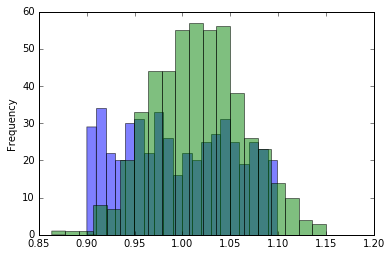

In [19]:
mc.draw(num_reals=500,how="uniform")
ax = plt.subplot(111)
mc.parensemble.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)
mc.draw(num_reals=500,how="gaussian")
mc.parensemble.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)

## null-space projection 

This is too easy.  Once you have drawn parameter realization, use the ```project_parensemble()``` method.  This method accepts 3 optional arguemnts: ``nsing``: number of singular components to demarcate the solution-null space boundary, ``par_file``: a pest .par file to use as the final parameter values, and ``inplace``, which is a boolean flag to control whether a new ```Ensemble``` instance should be created and returned.  The most important of these is ``nsing``.  If it is not passed, then ``nsing`` is set based on the ratio between the largest and smallest singular values >= 1.0e-6 

using 50 singular components


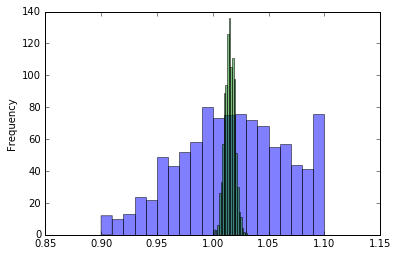

In [20]:
mc.draw(num_reals=1000,enforce_bounds=True)
ax = plt.subplot(111)
mc.parensemble.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)
mc.project_parensemble(nsing=50,par_file=jco.replace(".jcb",".par")) #use nsing=50 for demonstration purposes
mc.parensemble.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)

We see that if we use a large number of singular components, then the null-space projection process greatly reduces the uncertainty in the ``rch_1`` parameter.  Note that using 50 singular components greatly overeastimates the dimension of the range space of the normal matrix ($\mathbf{J}^T\mathbf{Q}\mathbf{J}$) and is likely not justifiable, since only 12 observations are being used for inversion. Let's redo the redo the null-space projection operation with 12 singular components:

using 12 singular components


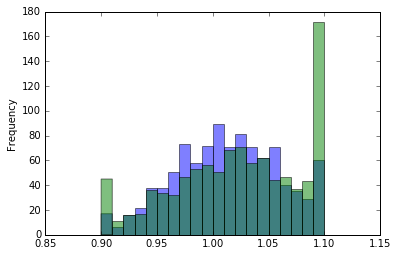

In [21]:
mc.draw(num_reals=1000,enforce_bounds=True)
ax = plt.subplot(111)
mc.parensemble.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)
mc.project_parensemble(nsing=12,par_file=jco.replace(".jcb",".par")) #use nsing=50 for demonstration purposes
mc.parensemble.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)

Now we see that the null-space projection operation only slightly increases the kurtosis of the distribution

## output
Once the desired type of ensemble has been generated, ``pyemu`` offers several ways to output the ensemble.  One option is to write a pest control file for each realization:

In [22]:
mc.draw(num_reals=10,enforce_bounds=True)
mc.project_parensemble()
mc.write_psts(jco.replace(".jcb","_real"),existing_jco="freyberg.jcb",noptmax=1)

using 12 singular components


or, optionally, write pest .par files:

In [23]:
mc.parensemble.to_parfiles(jco.replace(".jcb","_par_real"))

or, since the ``pyemu.Ensemble`` class is derived from the ``pandas.DataFrame``, we can also save the ensemble using any of the highly-optimized ``DataFrame`` output methods, such as ``.to_csv()``:

In [24]:
mc.parensemble.to_csv(jco+".csv")

## running the ensemble

This is the hard part - typically, evaluating the realizations will require some form of high-throughput, distributed computing.  This is why FOSM is so great!